### task 11

Combine xgboost, feature preprocessing and grid search in seed dataset:

In [24]:
!pip3 install xgboost
import xgboost as xgb

In [13]:
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
df = pd.read_csv("C:\\Users\\curly\\Documents\\Books\\CS4168- data mining\\lab\\Dataset\\seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [30]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

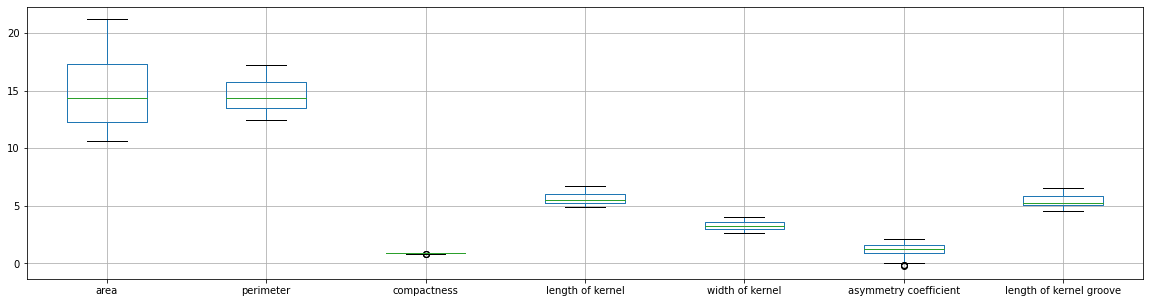

In [16]:
# don't have any empty value in dataset, and we have 3 types each have 70 instance
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

In [15]:
df['asymmetry coefficient'] = np.log(df['asymmetry coefficient'])

In [18]:
# store a list of column names except 'type'
names_all  = [c for c in df if c not in ['type']]

#prepare the name of  outlier and else
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [19]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    # add column name
    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [20]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("Does not include this column : %s" % cols_error)

In [21]:
# prepare the pipeline
preproces_pipeline = make_pipeline(
    AddColumnNames(columns = names_all),
    FeatureUnion(transformer_list = [
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            MinMaxScaler()
        ))]
        )
)

In [22]:
# split the data from test and train
# we know the type colum means the result so y is the type and x is cases without type
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [34]:
xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=2000,
            silent=True,
            objective='multi:softmax',
            num_class=3 ,          
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=0,
            missing=None,
            use_label_encoder=False)

In [35]:
pipe = Pipeline(steps=[('preprocess', preproces_pipeline), ('xgboost',xlf)])

In [ ]:
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]

}



gs = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gs.fit(X_train, y_train)

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set: %s" % gs.best_params_ )

C:\Users\curly\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\curly\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\curly\anaconda3\lib\site-packages\xgboost\core.py", line 433, in inner_f
    return f(**kwargs)
  File "C:\Users\curly\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1123, in fit
    raise ValueError(label_encoding_check_error)
ValueError: The label must consist of integer labels of form 0, 1, 2, ..., [num_class - 1].

  warnings.warn("Estimator fit failed. The score on this train-test"
